<a href="https://colab.research.google.com/github/KirolosThabet/IoT-Project/blob/main/IoT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [24]:
!pip install boruta
from boruta import BorutaPy

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score
from scipy.optimize import brentq
from scipy.interpolate import interp1d

In [26]:
np.int = np.int32
np.float = np.float64
np.bool = np.bool_

In [27]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [28]:
import os
from pathlib import Path
# Path to the data directory
directory = "/content/gdrive/MyDrive/Colab_Notebooks/CNC_Mill_Tool_Wear_Dataset/"

In [29]:
# Read the CSV file to obtain the general data from 18 different experiments
train_df = pd.read_csv(directory + 'train.csv')
exp_numbers_with_dev_feed_rate = train_df['feedrate'].tolist()

# Define a list to store the data for each experiment
experiment_data = []

In [30]:
# Iterate through each experiment file
for i in range(1, 19):
    # Construct the file path for the current experiment
    file_name = f'experiment_{i:02d}.csv'
    file_path = directory + file_name

    # Read the CSV file into a Pandas DataFrame
    df = pd.read_csv(file_path)

    # Extract the required features
    features = df[[
        'X1_ActualPosition', 'X1_ActualVelocity', 'X1_ActualAcceleration', 'X1_CommandPosition',
        'X1_CommandVelocity', 'X1_CommandAcceleration', 'X1_CurrentFeedback', 'X1_DCBusVoltage',
        'X1_OutputCurrent', 'X1_OutputVoltage', 'X1_OutputPower', 'Y1_ActualPosition',
        'Y1_ActualVelocity', 'Y1_ActualAcceleration', 'Y1_CommandPosition', 'Y1_CommandVelocity',
        'Y1_CommandAcceleration', 'Y1_CurrentFeedback', 'Y1_DCBusVoltage', 'Y1_OutputCurrent',
        'Y1_OutputVoltage', 'Y1_OutputPower', 'Z1_ActualPosition', 'Z1_ActualVelocity',
        'Z1_ActualAcceleration', 'Z1_CommandPosition', 'Z1_CommandVelocity', 'Z1_CommandAcceleration',
        'Z1_CurrentFeedback', 'Z1_DCBusVoltage', 'Z1_OutputCurrent', 'Z1_OutputVoltage',
        'S1_ActualPosition', 'S1_ActualVelocity', 'S1_ActualAcceleration', 'S1_CommandPosition',
        'S1_CommandVelocity', 'S1_CommandAcceleration', 'S1_CurrentFeedback', 'S1_DCBusVoltage',
        'S1_OutputCurrent', 'S1_OutputVoltage', 'S1_OutputPower', 'S1_SystemInertia',
        'M1_CURRENT_PROGRAM_NUMBER', 'M1_sequence_number', 'M1_CURRENT_FEEDRATE',
        'Machining_Process'

    ]]

    # Store the experiment number and features separately
    experiment_data.append({'experiment_number': i, 'features': features})

print('Data Imported')

Data Imported


#### Pre Processing Step

In [31]:
# Preprocessing function
def preprocess_data(df, exp_number, dev_feed_rate):

    s_shape_dimensions = (25, 35)
    s_shape_center = (140+s_shape_dimensions[0]/2, 72+s_shape_dimensions[0]/2)
    s_shape_left = s_shape_center[0] - s_shape_dimensions[0] / 2
    s_shape_right = s_shape_center[0] + s_shape_dimensions[0] / 2
    s_shape_bottom = s_shape_center[1] - s_shape_dimensions[1] / 2
    s_shape_top = s_shape_center[1] + s_shape_dimensions[1] / 2

    # Preprocessing 1: Filter out rows where Machining_Process is not in specified processes
    valid_processes = ['Layer 1 Up','Layer 2 Up','Layer 3 Up', 'Layer 1 Down', 'Layer 2 Down','Layer 3 Down']
    df = df[df['Machining_Process'].isin(valid_processes)]

    # Convert dev_feed_rate to a list if it's not already
    if not isinstance(dev_feed_rate, list):
        dev_feed_rate = [dev_feed_rate]

    # Preprocessing 2: Filter out rows where Machining_Process is not in specified processes
    dev_feed_rate = [val for val in dev_feed_rate if not pd.isna(val)]

    # Preprocessing 2: Filter the data based on the specified condition
    df = df[df['M1_CURRENT_FEEDRATE'].isin([int(val) for val in dev_feed_rate])]

    # Presprocessing 3: Function to eliminate deviated points from S shape
    df = df[(df['X1_ActualPosition'] >= s_shape_left) &
            (df['X1_ActualPosition'] <= s_shape_right) &
            (df['Y1_ActualPosition'] >= s_shape_bottom) &
            (df['Y1_ActualPosition'] <= s_shape_top)]

    return df

In [32]:
# Preprocess each experiment data
preprocessed_experiment_data = []

for experiment, feed_rate in zip(experiment_data, exp_numbers_with_dev_feed_rate):
    experiment_number = experiment['experiment_number']
    features = experiment['features']
    preprocessed_features = preprocess_data(features, experiment_number, feed_rate)
    preprocessed_experiment_data.append({'experiment_number': experiment_number, 'features': preprocessed_features})

print('Preprocessing Done')

Preprocessing Done


Collect All Preprocessed Points in one Array:

In [33]:
# Create an array of preprocessed data
preprocessed_array = []

# Iterate through each preprocessed experiment
for experiment in preprocessed_experiment_data:
    features = experiment['features']
    for _, row in features.iterrows():
        data_point = row[:-1].tolist()  # Exclude 'Machining_Process'
        feed_rate = train_df.loc[train_df['feedrate'] == row['M1_CURRENT_FEEDRATE'], 'feedrate'].values[0]
        clamp_pressure = train_df.loc[train_df['feedrate'] == row['M1_CURRENT_FEEDRATE'], 'clamp_pressure'].values[0]
        label = train_df.loc[train_df['feedrate'] == row['M1_CURRENT_FEEDRATE'], 'tool_condition'].values[0]
        label = np.where(label == 'worn', 1, 0)
        data_point.extend([feed_rate, clamp_pressure, label])
        preprocessed_array.append(data_point)

preprocessed_array = np.array(preprocessed_array)

print("Shape of preprocessed array:", preprocessed_array.shape)


Shape of preprocessed array: (10580, 50)


## Data Splitting

In [34]:
# Splitting preprocessed_array into X and Y
X = preprocessed_array[:, :-1]  # Features (all columns except the last one)
Y = preprocessed_array[:, -1]   # Labels (last column)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

print('Data Spliting Done')
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Data Spliting Done
Shape of X_train: (7406, 49)
Shape of X_test: (3174, 49)
Shape of y_train: (7406,)
Shape of y_test: (3174,)


## Apply Boruta Algorithm

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	9
Tentative: 	24
Rejected: 	16
Iteration: 	9 / 100
Confirmed: 	9
Tentative: 	24
Rejected: 	16
Iteration: 	10 / 100
Confirmed: 	9
Tentative: 	24
Rejected: 	16
Iteration: 	11 / 100
Confirmed: 	9
Tentative: 	24
Rejected: 	16
Iteration: 	12 / 100
Confirmed: 	12
Tentative: 	21
Rejected: 	16
Iteration: 	13 / 100
Confirmed: 	12
Tentative: 	19
Rejected: 	18
Iteration: 	14 / 100
Confirmed: 	12
Tentative: 	19
Rejected: 	18
Iteration: 	15 / 100
Confirmed: 	12
Tentative: 	19
Rejected: 	18
Iteration: 	16 / 100
Confirmed: 	12
Tentative: 	16
R

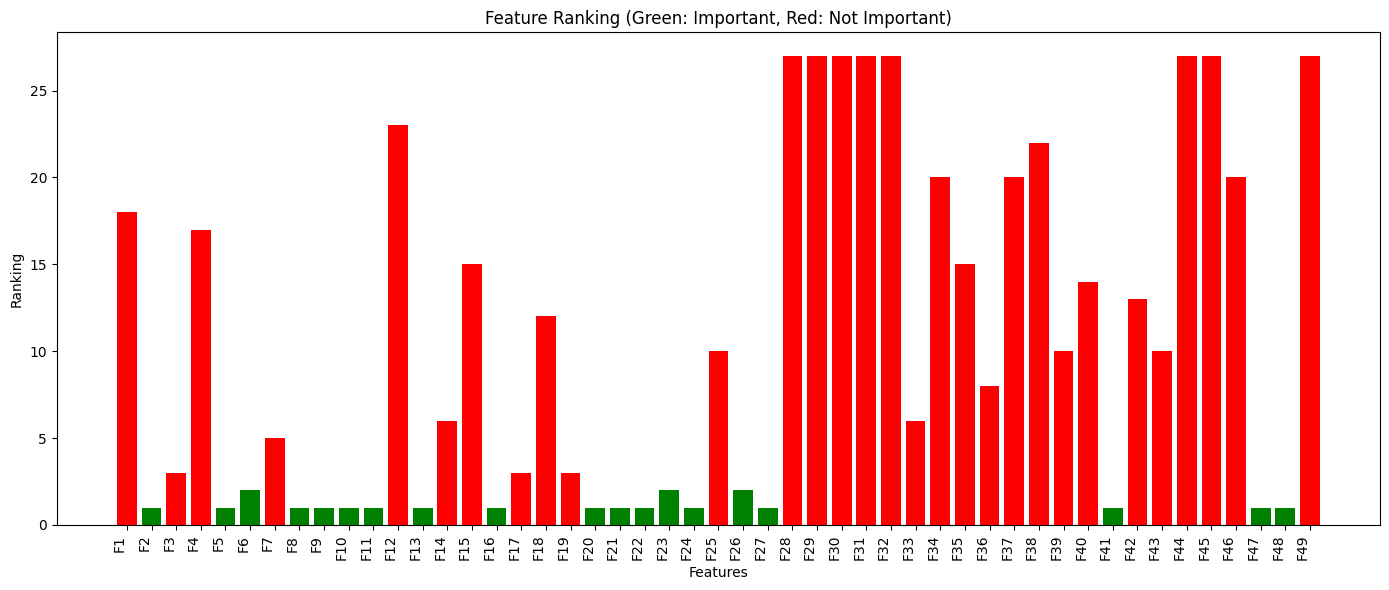

Feature Extraction Done


In [35]:
# Define a RandomForestClassifier
forest = RandomForestClassifier(n_jobs=-1, class_weight='balanced',random_state=42, n_estimators=100, max_depth=5)

# Apply Boruta
boruta_selector = BorutaPy(forest, n_estimators=10, verbose=2, random_state=42)

# Fit the Boruta selector
boruta_selector.fit(X_train, y_train)

# Check selected features
selected_features = [f for f, s in zip(range(X_train.shape[1]), boruta_selector.support_) if s]
print("Selected Features:", selected_features)

# Check ranking of features
print("Feature ranking:", boruta_selector.ranking_)

# Get important features
important_features = [f for f, r in zip(range(X_train.shape[1]), boruta_selector.ranking_) if r < 3]
print("Important Features:", important_features)


# Plot the feature importances
plt.figure(figsize=(14,6))

# Bar plot for feature ranking
plt.bar(range(X_train.shape[1]), boruta_selector.ranking_, color=np.where(boruta_selector.ranking_ < 3, 'green', 'red'))

# Highlight important features
for f in important_features:
    plt.bar(f, boruta_selector.ranking_[f], color='green')

plt.xlabel("Features")
plt.ylabel("Ranking")
plt.title("Feature Ranking (Green: Important, Red: Not Important)")
plt.xticks(range(X_train.shape[1]), ['F{}'.format(i+1) for i in range(X_train.shape[1])], rotation=90, ha='right')
plt.tight_layout()
plt.show()


print('Feature Extraction Done')

Model Development

In [36]:
# Traing and testing set after feature extraction
X_train_selc = boruta_selector.transform(X_train)
X_test_selc = boruta_selector.transform(X_test)

##### Model Develpment ############
models = {
    "Model 1": LogisticRegression(max_iter=1000, C=1.0),
    "Model 2": LogisticRegression(max_iter=1000, C=0.5),
    "Model 3": LogisticRegression(max_iter=1000, C=0.1),
    "Model 4": LogisticRegression(max_iter=1000, C=0.01),
    "Model 5": LogisticRegression(max_iter=1000, C=0.001)
}

# AIC values and residuals
aic_values = {}
residuals = {}
auc_values = {}

for name, model in models.items():
    model.fit(X_train_selc, y_train)
    y_prob = model.predict_proba(X_test_selc)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    auc_val = auc(fpr, tpr)
    auc_values[name] = auc_val
    aic_values[name] = 2 * len(important_features) - 2 * np.log(np.maximum(1e-10, auc_val))
    residuals[name] = np.sum(np.square(y_test - model.predict(X_test_selc)))

# Select the best initial model
best_initial_model = min(aic_values, key=lambda x: (aic_values[x], residuals[x]))
print("Best Initial Model by AIC values:", best_initial_model)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best Initial Model by AIC values: Model 1


K Folds Cross Validation

In [37]:
# Define the number of splits for K-fold cross-validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Dictionary to store the p-values for each model
p_values = {}

for name, model in models.items():
    p_values[name] = []
    for train_index, val_index in kf.split(X_train_selc):
        X_train_kf, X_val_kf = X_train_selc[train_index], X_train_selc[val_index]
        y_train_kf, y_val_kf = y_train[train_index], y_train[val_index]
        model.fit(X_train_kf, y_train_kf)
        # Get the p-value for the current validation set
        y_prob = model.predict_proba(X_val_kf)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_val_kf, y_prob)
        p_value = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
        # Store the p-value
        p_values[name].append(p_value)

# Print p-values
for name, p_value in p_values.items():
    print(f"P-values for {name}: {p_value}")

# Select the model based on improvement in p-value
best_model_kfold = best_initial_model
for name, p_value in p_values.items():
    if name == best_initial_model:
        continue
    if np.mean(p_value) < np.mean(p_values[best_model_kfold]):
        best_model_kfold = name

print("Best Model after K-fold Cross-Validation:", best_model_kfold)

# Dictionary to store deviance residual values for each model and fold
deviance_residuals = {model_name: [] for model_name in models.keys()}

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

P-values for Model 1: [0.06043165467725646, 0.06446991404103655, 0.06618705036017883, 0.06854256854236383, 0.06101938262743419]
P-values for Model 2: [0.0604316546758225, 0.06661891117352826, 0.06593406593406041, 0.06998556998467331, 0.06101938262781507]
P-values for Model 3: [0.059712230216415585, 0.06518624641757204, 0.06546762589813593, 0.06709956710001112, 0.06101938262804148]
P-values for Model 4: [0.05971223021642111, 0.06518624641894966, 0.03741007194346428, 0.06709956710092527, 0.06101938262813158]
P-values for Model 5: [0.05683453237530161, 0.06661891117389512, 0.06474820143922673, 0.06709956710015985, 0.06101938262778713]
Best Model after K-fold Cross-Validation: Model 4


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

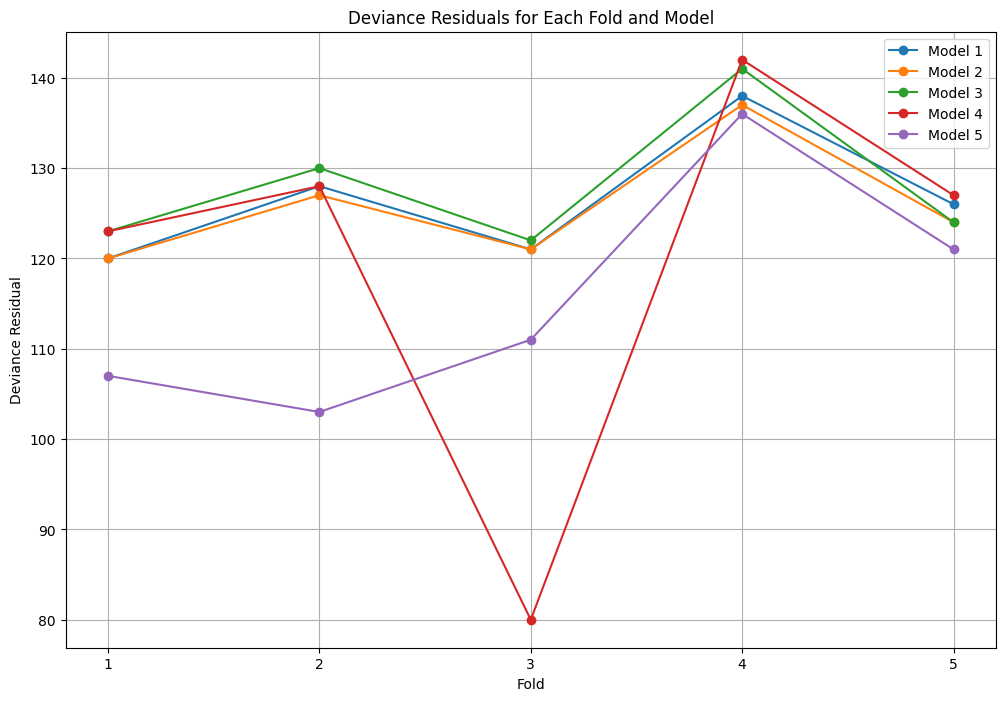

Best Model Selected


In [38]:
# Perform K-fold cross-validation
for fold_idx, (train_index, val_index) in enumerate(kf.split(X_train_selc)):
    X_train_fold, X_val_fold = X_train_selc[train_index], X_train_selc[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Train each model on the current fold
    for model_name, model in models.items():
        model.fit(X_train_fold, y_train_fold)
        # Calculate deviance residuals for the current fold and model
        deviance_residual = np.sum(np.square(y_val_fold - model.predict(X_val_fold)))
        deviance_residuals[model_name].append(deviance_residual)

# Plot the deviance residuals for each fold and model
plt.figure(figsize=(12, 8))
for model_name, residuals_list in deviance_residuals.items():
    plt.plot(range(1, k + 1), residuals_list, marker='o', label=model_name)

plt.title('Deviance Residuals for Each Fold and Model')
plt.xlabel('Fold')
plt.ylabel('Deviance Residual')
plt.xticks(range(1, k + 1))
plt.legend()
plt.grid(True)
plt.show()

print("Best Model Selected")

Optimal Threshold

In [39]:
# Train the best model using the whole training dataset
best_model = models[best_model_kfold]
best_model.fit(X_train_selc, y_train)
y_proba = best_model.predict_proba(X_train_selc)[:, 1]

# Find the optimal threshold
fpr, tpr, thresholds = roc_curve(y_train, y_proba)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Evaluate using k-fold cross-validation
conf_matrices = []
for train_index, test_index in kf.split(X_train_selc):
    X_train_fold, X_test_fold = X_train_selc[train_index], X_train_selc[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    best_model.fit(X_train_fold, y_train_fold)
    y_proba_fold = best_model.predict_proba(X_test_fold)[:, 1]
    conf_matrices.append(confusion_matrix(y_test_fold, y_proba_fold > optimal_threshold))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


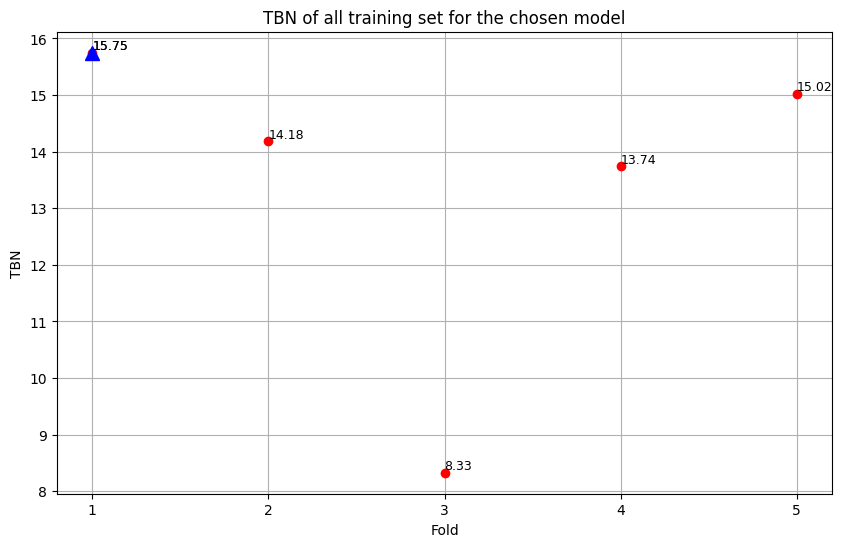

Best Training Set (K): 1
Optimum Threshold: 0.0629501177220005


In [40]:
# Calculate TBN, Sensitivity, Specificity for each fold
TBNs = []
sensitivities = []
specificities = []

for conf_matrix in conf_matrices:
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    TP = conf_matrix[1][1]

    TBN = TN / (FP + FN)
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    TBNs.append(TBN)
    sensitivities.append(sensitivity)
    specificities.append(specificity)


# Plot TBN of all training set for the chosen model
plt.figure(figsize=(10, 6))
for i, conf_matrix in enumerate(conf_matrices):
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    TP = conf_matrix[1][1]

    TBN = TN / (FP + FN)
    plt.plot(i+1, TBN, 'ro')
    plt.text(i+1, TBN, f'{TBN:.2f}', fontsize=9, va='bottom')

best_k = np.argmax(TBNs) + 1
best_TBN = max(TBNs)
plt.plot(best_k, best_TBN, 'b^', markersize=10)
plt.text(best_k, best_TBN, f'{best_TBN:.2f}', fontsize=9, va='bottom')

plt.title('TBN of all training set for the chosen model')
plt.xlabel('Fold')
plt.ylabel('TBN')
plt.xticks(range(1, k + 1))
plt.grid(True)
plt.show()

print("Best Training Set (K):", best_k)
print("Optimum Threshold:", optimal_threshold)


Visualizing Model Performance

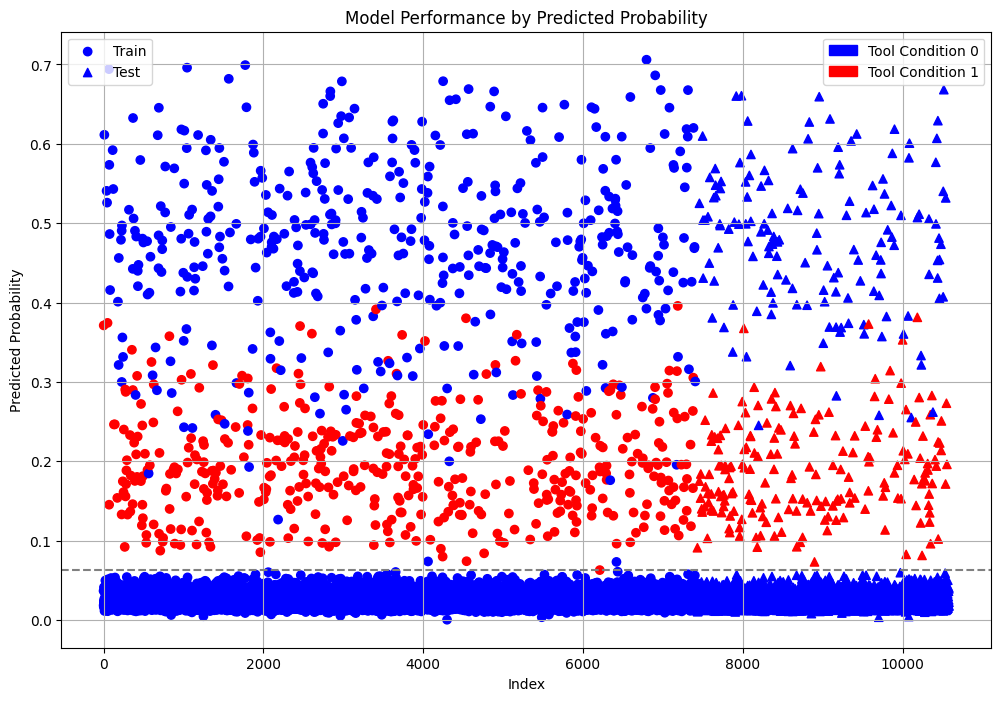

Accuracy of the model: 0.9521109010712036


In [41]:
# Train the best model using the whole training dataset
best_model = models[best_model_kfold]
best_model.fit(X_train_selc, y_train)

# Predict probabilities for both train and test sets
y_proba_train = best_model.predict_proba(X_train_selc)[:, 1]
y_proba_test = best_model.predict_proba(X_test_selc)[:, 1]

# Prepare color for Tool Condition
colors_train = np.where(y_train == 0, 'blue', 'red')
colors_test = np.where(y_test == 0, 'blue', 'red')

# Prepare marker for Train and Test sets
marker_train = 'o'
marker_test = '^'

# Plot the predicted probabilities
plt.figure(figsize=(12, 8))
scatter_train = plt.scatter(range(len(y_train)), y_proba_train, color=colors_train, label='Train', marker=marker_train)
scatter_test = plt.scatter(range(len(y_train), len(y_train) + len(y_test)), y_proba_test, color=colors_test, label='Test', marker=marker_test)

plt.axhline(y=optimal_threshold, color='gray', linestyle='--', label='Optimal Threshold')

# Legend for color
blue_patch = mpatches.Patch(color='blue', label='Tool Condition 0')
red_patch = mpatches.Patch(color='red', label='Tool Condition 1')

# Creating the legend
legend1 = plt.legend(handles=[blue_patch, red_patch], loc="upper right")

# Adding the marker color to the legend
legend2 = plt.legend([scatter_train, scatter_test], ['Train', 'Test'], loc="upper left")
plt.gca().add_artist(legend1)

plt.xlabel('Index')
plt.ylabel('Predicted Probability')
plt.title('Model Performance by Predicted Probability')
plt.grid(True)
plt.show()

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_proba_test > optimal_threshold)
print("Accuracy of the model:", accuracy)

# Model Development Using SVM

In [42]:
from sklearn.svm import SVC
models = {
    "Model 1": SVC(kernel='linear', C=1.0, probability=True),
    "Model 2": SVC(kernel='linear', C=0.5, probability=True),
    "Model 3": SVC(kernel='linear', C=0.1, probability=True),
    "Model 4": SVC(kernel='linear', C=0.01, probability=True),
    "Model 5": SVC(kernel='linear', C=0.001, probability=True)
}

# AIC values and residuals
aic_values = {}
residuals = {}
auc_values = {}


for name, model in models.items():
    model.fit(X_train_selc, y_train)
    y_prob = model.predict_proba(X_test_selc)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    auc_val = auc(fpr, tpr)
    auc_values[name] = auc_val
    aic_values[name] = 2 * len(important_features) - 2 * np.log(np.maximum(1e-10, auc_val))
    residuals[name] = np.sum(np.square(y_test - model.predict(X_test_selc)))

# Select the best initial model
best_initial_model = min(aic_values, key=lambda x: (aic_values[x], residuals[x]))
print("Best Initial Model by AIC values:", best_initial_model)


Best Initial Model by AIC values: Model 1


K-fold Cross-Validation

In [43]:
# Define the number of splits for K-fold cross-validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Dictionary to store the p-values for each model
p_values = {}

for name, model in models.items():
    p_values[name] = []
    for train_index, val_index in kf.split(X_train_selc):
        X_train_kf, X_val_kf = X_train_selc[train_index], X_train_selc[val_index]
        y_train_kf, y_val_kf = y_train[train_index], y_train[val_index]
        model.fit(X_train_kf, y_train_kf)
        # Get the p-value for the current validation set
        y_prob = model.predict_proba(X_val_kf)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_val_kf, y_prob)
        p_value = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
        # Store the p-value
        p_values[name].append(p_value)

# Print p-values
for name, p_value in p_values.items():
    print(f"P-values for {name}: {p_value}")

# Select the model based on improvement in p-value
best_model_kfold = best_initial_model
for name, p_value in p_values.items():
    if name == best_initial_model:
        continue
    if np.mean(p_value) < np.mean(p_values[best_model_kfold]):
        best_model_kfold = name

print("Best Model after K-fold Cross-Validation:", best_model_kfold)


P-values for Model 1: [0.053956834531363684, 0.04871060172029701, 0.03956834532276021, 0.0526315789473679, 0.053840631730657035]
P-values for Model 2: [0.052517985610793745, 0.05014326647614006, 0.03669064748252095, 0.051948051947075254, 0.05455850682043359]
P-values for Model 3: [0.051079136690592525, 0.04727793696378785, 0.03597122302290122, 0.054112554112816194, 0.05455850681900737]
P-values for Model 4: [0.05035971222928232, 0.05157593123311118, 0.04316546762519198, 0.05844155844271631, 0.057430007180184456]
P-values for Model 5: [0.04892086331016039, 0.047058823529437535, 0.0395683453230261, 0.05772005772012432, 0.0502512562822682]
Best Model after K-fold Cross-Validation: Model 3


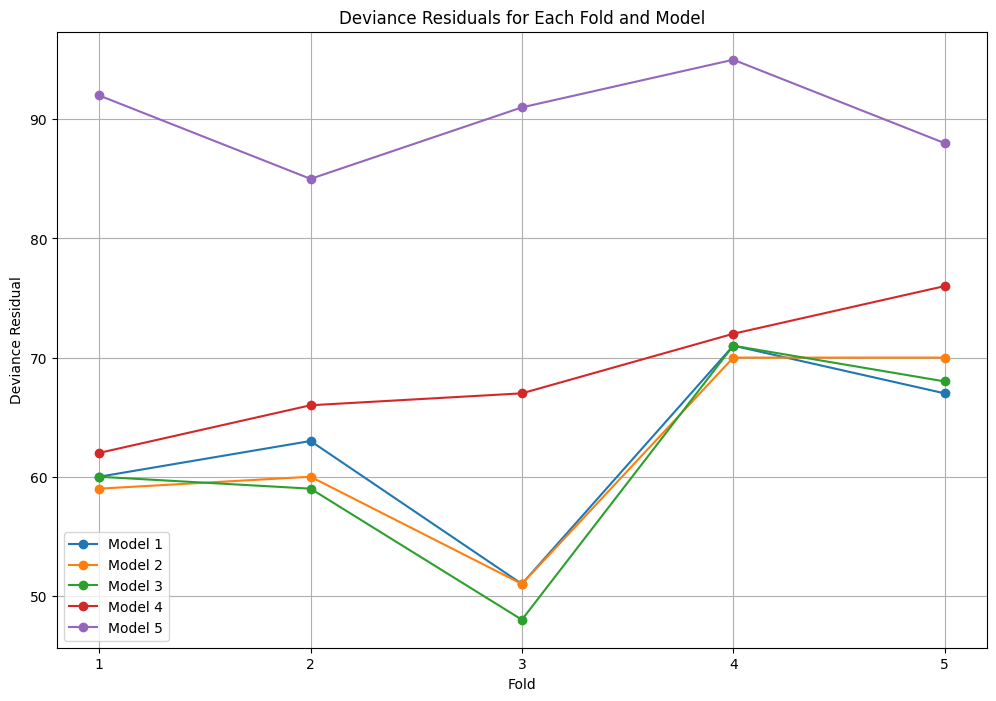

Best Model Selected


In [44]:
# Dictionary to store deviance residual values for each model and fold
deviance_residuals = {model_name: [] for model_name in models.keys()}

# Perform K-fold cross-validation
for fold_idx, (train_index, val_index) in enumerate(kf.split(X_train_selc)):
    X_train_fold, X_val_fold = X_train_selc[train_index], X_train_selc[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Train each model on the current fold
    for model_name, model in models.items():
        model.fit(X_train_fold, y_train_fold)
        # Calculate deviance residuals for the current fold and model
        deviance_residual = np.sum(np.square(y_val_fold - model.predict(X_val_fold)))
        deviance_residuals[model_name].append(deviance_residual)

# Plot the deviance residuals for each fold and model
plt.figure(figsize=(12, 8))
for model_name, residuals_list in deviance_residuals.items():
    plt.plot(range(1, k + 1), residuals_list, marker='o', label=model_name)

plt.title('Deviance Residuals for Each Fold and Model')
plt.xlabel('Fold')
plt.ylabel('Deviance Residual')
plt.xticks(range(1, k + 1))
plt.legend()
plt.grid(True)
plt.show()

print("Best Model Selected")

Finding Optimal Threshold

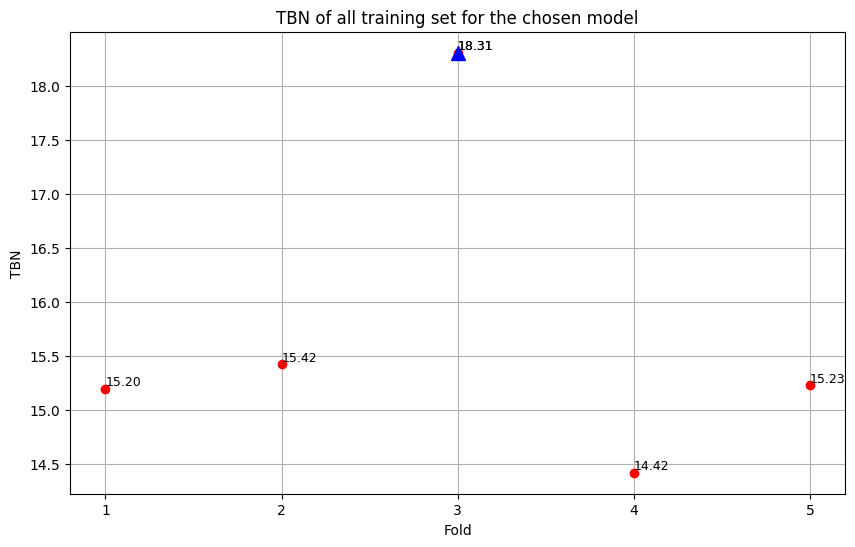

Best Training Set (K): 3
Optimum Threshold: 0.13677550343921688


In [45]:
# Train the best model using the whole training dataset
best_model = models[best_model_kfold]
best_model.fit(X_train_selc, y_train)
y_proba = best_model.predict_proba(X_train_selc)[:, 1]

# Find the optimal threshold
fpr, tpr, thresholds = roc_curve(y_train, y_proba)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Evaluate using k-fold cross-validation
conf_matrices = []
for train_index, test_index in kf.split(X_train_selc):
    X_train_fold, X_test_fold = X_train_selc[train_index], X_train_selc[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    best_model.fit(X_train_fold, y_train_fold)
    y_proba_fold = best_model.predict_proba(X_test_fold)[:, 1]
    conf_matrices.append(confusion_matrix(y_test_fold, y_proba_fold > optimal_threshold))

# Calculate TBN, Sensitivity, Specificity for each fold
TBNs = []
sensitivities = []
specificities = []

for conf_matrix in conf_matrices:
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    TP = conf_matrix[1][1]

    TBN = TN / (FP + FN)
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)

    TBNs.append(TBN)
    sensitivities.append(sensitivity)
    specificities.append(specificity)


# Plot TBN of all training set for the chosen model
plt.figure(figsize=(10, 6))
for i, conf_matrix in enumerate(conf_matrices):
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    TP = conf_matrix[1][1]

    TBN = TN / (FP + FN)
    plt.plot(i+1, TBN, 'ro')
    plt.text(i+1, TBN, f'{TBN:.2f}', fontsize=9, va='bottom')

best_k = np.argmax(TBNs) + 1
best_TBN = max(TBNs)
plt.plot(best_k, best_TBN, 'b^', markersize=10)
plt.text(best_k, best_TBN, f'{best_TBN:.2f}', fontsize=9, va='bottom')

plt.title('TBN of all training set for the chosen model')
plt.xlabel('Fold')
plt.ylabel('TBN')
plt.xticks(range(1, k + 1))
plt.grid(True)
plt.show()

print("Best Training Set (K):", best_k)
print("Optimum Threshold:", optimal_threshold)


Visualizing Model Performance

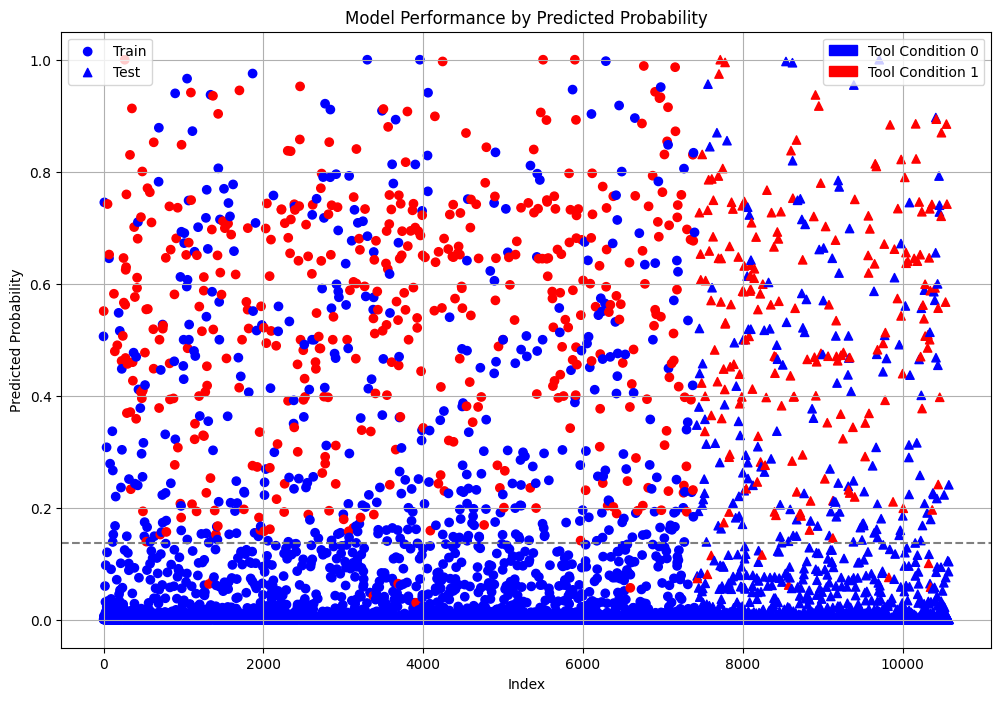

Accuracy of the model: 0.9448645242596093


In [46]:
# Train the best model using the whole training dataset
best_model = models[best_model_kfold]
best_model.fit(X_train_selc, y_train)

# Predict probabilities for both train and test sets
y_proba_train = best_model.predict_proba(X_train_selc)[:, 1]
y_proba_test = best_model.predict_proba(X_test_selc)[:, 1]

# Prepare color for Tool Condition
colors_train = np.where(y_train == 0, 'blue', 'red')
colors_test = np.where(y_test == 0, 'blue', 'red')

# Prepare marker for Train and Test sets
marker_train = 'o'
marker_test = '^'

# Plot the predicted probabilities
plt.figure(figsize=(12, 8))
scatter_train = plt.scatter(range(len(y_train)), y_proba_train, color=colors_train, label='Train', marker=marker_train)
scatter_test = plt.scatter(range(len(y_train), len(y_train) + len(y_test)), y_proba_test, color=colors_test, label='Test', marker=marker_test)

plt.axhline(y=optimal_threshold, color='gray', linestyle='--', label='Optimal Threshold')

# Legend for color
blue_patch = mpatches.Patch(color='blue', label='Tool Condition 0')
red_patch = mpatches.Patch(color='red', label='Tool Condition 1')

# Creating the legend
legend1 = plt.legend(handles=[blue_patch, red_patch], loc="upper right")

# Adding the marker color to the legend
legend2 = plt.legend([scatter_train, scatter_test], ['Train', 'Test'], loc="upper left")
plt.gca().add_artist(legend1)

plt.xlabel('Index')
plt.ylabel('Predicted Probability')
plt.title('Model Performance by Predicted Probability')
plt.grid(True)
plt.show()

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_proba_test > optimal_threshold)
print("Accuracy of the model:", accuracy)